<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/MMTrack_and_MMPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ライブラリインストール
!pip install mmcv-full

!git clone https://github.com/open-mmlab/mmtracking.git
%cd mmtracking
!pip install -r requirements/build.txt
!pip install -v -e .
%cd ..

!git clone https://github.com/open-mmlab/mmpose.git
%cd mmpose
!pip install -r requirements.txt
# !python setup.py develop
!pip install -v -e .
%cd ..

!pip install mmdet

!pip uninstall numpy
!pip install numpy


     |████████████████████████████████| 286kB 23.2MB/s 
     |████████████████████████████████| 194kB 42.3MB/s 
  Created wheel for mmcv-full: filename=mmcv_full-1.3.3-cp37-cp37m-linux_x86_64.whl size=24563330 sha256=128cb5fa7f7c2e7ae2086bd03abb78775c6604ec25661a32c3b72ceb2da74823
  Stored in directory: /root/.cache/pip/wheels/57/2a/55/762bce3ae6e1ef4eee0419cefa3229a6d30892e058345629f4
Successfully built mmcv-full
Cloning into 'mmtracking'...
remote: Enumerating objects: 1424, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1424 (delta 31), reused 39 (delta 17), pack-reused 1351
Receiving objects: 100% (1424/1424), 956.06 KiB | 22.76 MiB/s, done.
Resolving deltas: 100% (743/743), done.
/content/mmtracking
Created temporary directory: /tmp/pip-ephem-wheel-cache-1x3ky5mg
Created temporary directory: /tmp/pip-req-tracker-rikwmmdb
Created requirements tracker '/tmp/pip-req-tracker-rikwmmdb'
Created temporary directory: /tmp

In [ ]:
# 一度ランタイムを再起動する(Ctrl+M)。

In [ ]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob, pickle, time, gc, copy, sys
import warnings
import cv2
warnings.filterwarnings('ignore')
import torch
import mmcv
sys.path.append('mmtracking')
from mmtrack.apis import inference_mot, init_model
sys.path.append('mmpose')
from mmpose.apis import inference_top_down_pose_model, init_pose_model, vis_pose_result
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# サンプル動画読み込み
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = "1x53zUXIKL4ci61TkajNcKIGK2RhTz8Z0"
drive_file = drive.CreateFile({'id': file_id})
drive_file.GetContentFile("demo.mp4") # 左のファイルメニューからdemo.mp4をダウンロード可能に

In [ ]:
# 動画リーダーを用意
imgs = mmcv.VideoReader("demo.mp4")
fps = imgs.fps
print(fps)
print(len(imgs))

29.97
445


In [ ]:
# Object Trackingモデルの読み込み
"""
モデルはdetectionにFaster R-CNN、trackingにDeepSORTを使用している。
より性能が高いSELSAなどもmmtrackingでは選べるが依存ライブラリのバージョンのコンフリクトで動かなかった。
"""
track_model = init_model(
    "mmtracking/configs/mot/deepsort/sort_faster-rcnn_fpn_4e_mot17-private.py",
    None,
    device='cuda:0'
)
print(track_model)

2021-05-05 21:57:02,118 - mmtrack - INFO - load detector from: https://download.openmmlab.com/mmtracking/mot/faster_rcnn/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth
2021-05-05 21:57:02,119 - mmtrack - INFO - Use load_from_http loader
Downloading: "https://download.openmmlab.com/mmtracking/mot/faster_rcnn/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth" to /root/.cache/torch/hub/checkpoints/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth



DeepSORT(
  (detector): FasterRCNN(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): ResLayer(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [ ]:
# Object Trackingの実行
prog_bar = mmcv.ProgressBar(len(imgs))
# test and show/save the images
track_dir = "det"
os.makedirs(track_dir, exist_ok=True)
track_results = []
for i, img in enumerate(imgs): # 動画の各フレームについて
    result = inference_mot(track_model, img, frame_id=i) # trackingの実行
    track_results.append(result)
    output_path = track_dir + "/{:06d}.jpg".format(i) # 推定結果画像の出力先path
#     print(output_path)
    track_model.show_result(
        img,
        result['track_results'],
        show=False,
        wait_time=int(1000. / fps) if fps else 0,
        out_file=output_path,
        backend='cv2', # ['cv2', 'plt']
    )
    prog_bar.update()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 8.1 task/s, elapsed: 55s, ETA:     0s

In [ ]:
# 動画の書き出し
# 左のファイルメニューからトラッキング結果(tracking.mp4)をダウンロード可能に
mmcv.frames2video(track_dir, "tracking.mp4", fps=fps)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 106.3 task/s, elapsed: 4s, ETA:     0s


In [ ]:
"""
Tracking性能が十分でないので書き出した動画をコマ送りで目視して確認し
抽出したい人物のtracking IDをリストアップ
"""
select_list = [0,1,3,5,10,7,12,21,23,25,26,27,29,31,32,43,51,53,58,60,74,75,76,82,94,96,
               97,98,102,105,106,107,109,111,110,112,125,129,134,135,136,138,139,149,154,
               155,158,159,160,161,162,163,165,166,167,169,170,174,176,212,220,224,
               225,226,227,228,231,236,239,240,249,263,
]

In [ ]:
# tracking結果をselect_listを用いてフィルタリング
track_results_select = []
col_track = ['object_id', 'x1', 'y1', 'x2', 'y2', 'conf']
for frame in range(len(imgs)):
    result_select = []
    result = track_results[frame]['track_results'][0]
    df_result = pd.DataFrame(result, columns=col_track)
    df_result = df_result.sort_values('conf', ascending=False)
    df_result['select'] = df_result['object_id'].apply(lambda x: x in select_list)
    if df_result['select'].sum()>0:
        tracking = df_result[col_track][df_result['select']].values[0]
        tracking = [tracking.reshape(1,-1)]
    else:
        tracking = [np.zeros([0,6])]
    track_results_select.append(tracking)
track_results_select

[[array([[  0.        , 166.46011353,  47.98143387, 455.2197876 ,
          506.4085083 ,   0.83440459]])],
 [array([[  1.        , 280.91186523,  15.90893078, 761.45245361,
          518.40637207,   0.91659212]])],
 [array([[  3.        , 157.34379578,  10.45431709, 481.29742432,
          512.35162354,   0.90732616]])],
 [array([[  5.        ,  20.69282913, -67.91042328, 316.78952026,
          535.19958496,   0.77704561]])],
 [array([[ 5.00000000e+00, -1.21134663e+01, -7.18682706e-02,
           2.85393829e+02,  5.27718933e+02,  8.19843054e-01]])],
 [array([[   7.        , -104.47637177,  -15.55043793,  109.56621552,
           550.62237549,    0.81712359]])],
 [array([[  5.        ,  42.1589241 ,  10.86295795, 294.94351196,
          499.40969849,   0.97856414]])],
 [array([[  5.        ,  31.26014137, -38.28647232, 295.03152466,
          541.94085693,   0.99167669]])],
 [array([[  7.        , -87.55830383,  -2.08585668, 179.15118408,
          540.55316162,   0.94952017]])],
 [ar

In [ ]:
# 抽出したtracking情報を出力
select_dir = "select"
prog_bar = mmcv.ProgressBar(len(imgs))
for i, img in enumerate(imgs): # 動画の各フレームについて
    output_path = select_dir + "/{:06d}.jpg".format(i) # 推定結果画像の出力先path
    result = track_results_select[i]
    track_model.show_result(
        img,
        result,
        show=False,
        wait_time=int(1000. / fps) if fps else 0,
        out_file=output_path,
        backend='cv2', # ['cv2', 'plt']
    )
    prog_bar.update()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 106.2 task/s, elapsed: 4s, ETA:     0s

In [ ]:
# 動画を書き出し
# 左のファイルメニューから人物一人を抽出したトラッキング結果(tracking.mp4)をダウンロード可能に
mmcv.frames2video(select_dir, "tracking_selected.mp4", fps=fps)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 103.6 task/s, elapsed: 4s, ETA:     0s


In [ ]:
# pose推定モデルを読み込む
pose_model = init_pose_model(
    "mmpose/configs/top_down/hrnet/coco/hrnet_w48_coco_256x192.py", 
    "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth",
    device='cuda:0'
)
print(pose_model)

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth



TopDown(
  (backbone): HRNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
# pose推定を実行する
pose_dir = "pose"
os.makedirs(pose_dir, exist_ok=True)
prog_bar = mmcv.ProgressBar(len(imgs))
dataset = pose_model.cfg.data['test']['type']
for i, img in enumerate(imgs): # 動画の各フレームについて
    # img=GBR
    output_path = pose_dir + "/{:06d}.jpg".format(i) # 推定結果画像の出力先path
    person_results = []
    for j in range(len(track_results_select[i][0])):
        person = {}
        person['bbox'] = track_results_select[i][0][j][1:]
        person_results.append(person)
    pose_results, returned_outputs = inference_top_down_pose_model(
        pose_model,
        img,
        person_results,
        bbox_thr=0.3,
        format='xyxy',
        dataset=dataset,
        return_heatmap=False,
        outputs=None
    )
    vis_img = vis_pose_result(
        pose_model,
        img,
        pose_results,
        dataset=dataset,
        kpt_score_thr=0.3,
        show=False)
    cv2.imwrite(output_path, vis_img)
    prog_bar.update()

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 17.4 task/s, elapsed: 26s, ETA:     0s

In [ ]:
# 動画を書き出し
# 左のファイルメニューからpose推定結果(pose.mp4)をダウンロード可能に
mmcv.frames2video(pose_dir, "pose.mp4", fps=fps)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 445/445, 106.7 task/s, elapsed: 4s, ETA:     0s


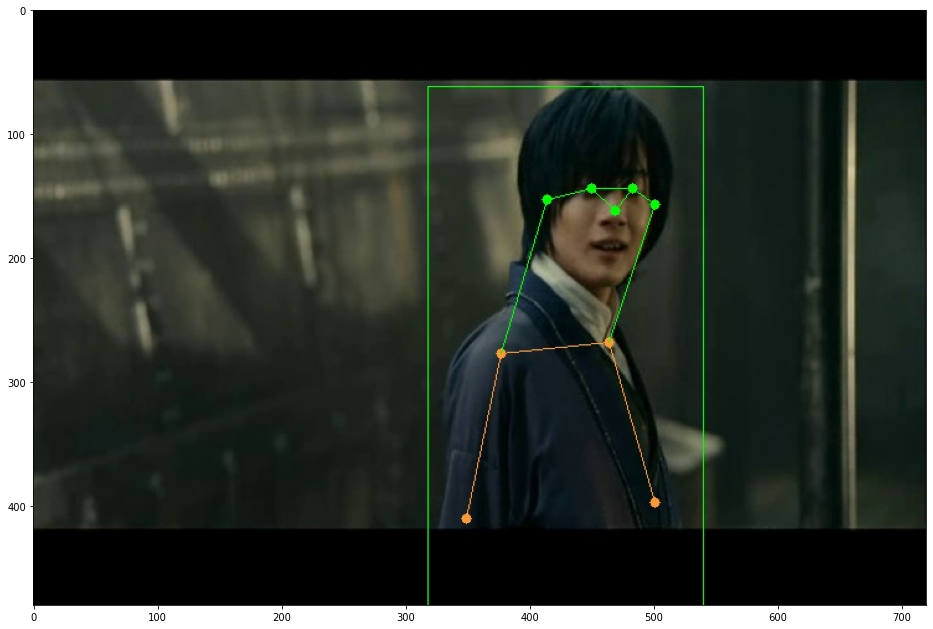

In [ ]:
# 推定結果を表示(画像)
img = cv2.imread("pose/000400.jpg")[:,:,::-1]
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.show()